In [1]:
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
%store -r rfm_log

# Clustering

In [3]:
rfm_k = rfm_log[['Recency', 'Frequency', 'Monetary']]
scaler = StandardScaler()
scaled = scaler.fit_transform(rfm_k.values)

In [4]:
sse = []
silhouette = []
kmax = 7
for k in range(2, kmax):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(scaled)
    sse.append(kmeans.inertia_)
    silhouette.append(silhouette_score(scaled, kmeans.labels_))

In [5]:
# Elbow curve.
#ax = plt.plot(range(2, kmax), sse)
#plt.show()

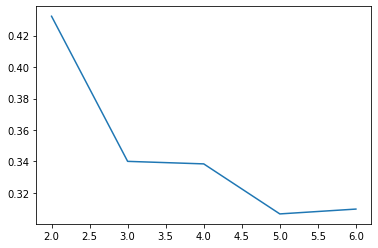

In [6]:
# Silhouette score.
ax = plt.plot(range(2, kmax), silhouette)
plt.show()

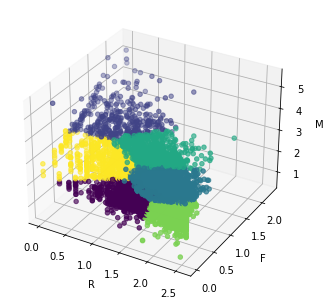

In [7]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(rfm_log['Recency'], rfm_log['Frequency'], rfm_log['Monetary'], c=kmeans.labels_)
ax.set_xlabel('R')
ax.set_ylabel('F')
ax.set_zlabel('M')
plt.show()

In [8]:
#rfm_den = rfm_log[['Frequency','Monetary','Recency']]
density = DBSCAN(eps=0.35, min_samples=7).fit(scaled)

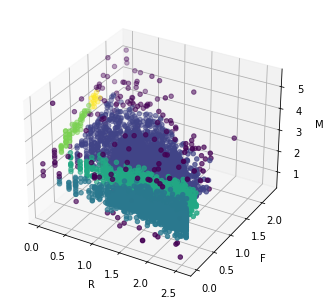

In [9]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(rfm_log['Recency'], rfm_log['Frequency'], rfm_log['Monetary'], c=density.labels_)
ax.set_xlabel('R')
ax.set_ylabel('F')
ax.set_zlabel('M')
plt.show()

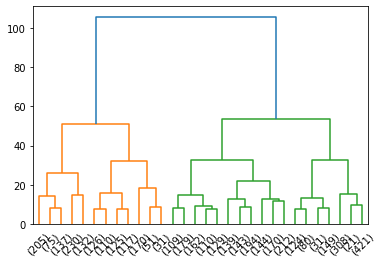

In [10]:
data_dist = pdist(scaled, metric='euclidean')
data_link = linkage(data_dist, method='ward', metric='euclidean')
res = dendrogram(data_link, truncate_mode='lastp')